In [2]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
df = pd.read_csv('ELC.csv', index_col='time', parse_dates=True)
df=df.drop(columns=['open', 'high', 'low', 'volume'])
df = df.reset_index(drop=True)
df.head()

,close
0,4409.937988
1,4347.826172
2,4347.826172
3,4347.826172
4,4335.403809


In [3]:
# 2. Đọc file csv và gắn index với Price
df1=df.reset_index()['close']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [4]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [5]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 65ms/step - loss: 0.0300 - val_loss: 0.0183
Epoch 2/100
14/14 [==============================] - 0s 24ms/step - loss: 0.0089 - val_loss: 0.0189
Epoch 3/100
14/14 [==============================] - 0s 23ms/step - loss: 0.0018 - val_loss: 8.5898e-04
Epoch 4/100
14/14 [==============================] - 0s 26ms/step - loss: 5.1604e-04 - val_loss: 8.2595e-04
Epoch 5/100
14/14 [==============================] - 0s 25ms/step - loss: 3.7854e-04 - val_loss: 6.6908e-04
Epoch 6/100
14/14 [==============================] - 0s 24ms/step - loss: 3.4181e-04 - val_loss: 6.4626e-04
Epoch 7/100
14/14 [==============================] - 0s 24ms/step - loss: 3.1776e-04 - val_loss: 6.6865e-04
Epoch 8/100
14/14 [==============================] - 0s 24ms/step - loss: 3.1099e-04 - val_loss: 6.4821e-04
Epoch 9/100
14/14 [==============================] - 0s 25ms/step - loss: 3.0047e-04 - val_loss: 5.7632e-04
Epoch 10/100
14/14 [============================

In [6]:
# Dự báo dữ liệu test
y_pred = model.predict(X_test)

# Chuẩn hóa dữ liệu y_pred
y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

12/12 [==============================] - 0s 5ms/step


In [7]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAPE và MLSE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 502.5468
MAPE trên tập test là: 2.2352758795022964 %
MSLE trên tập test là: 0.0009358587


In [8]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        lst_output.extend(y_hat.tolist())

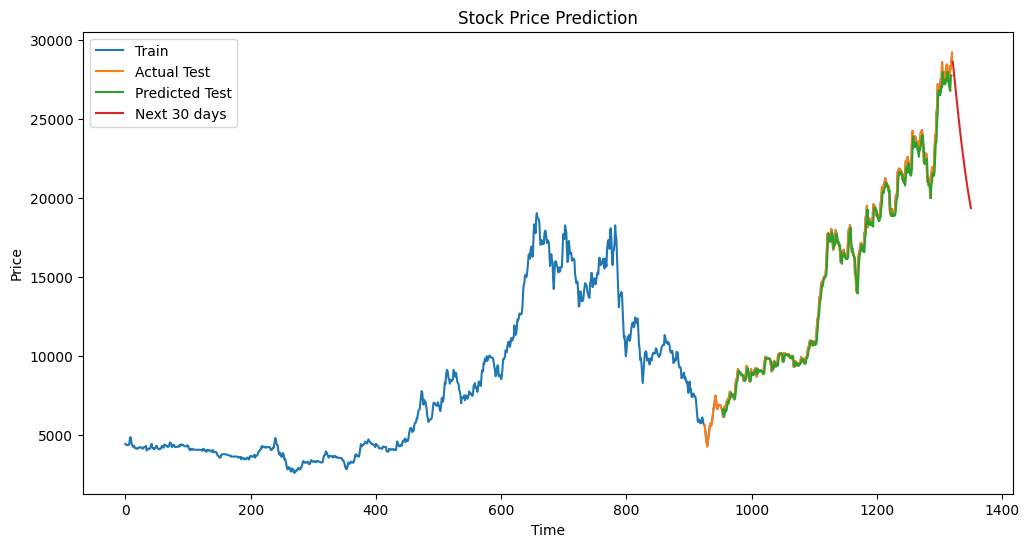

In [9]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()


# (Split 8/2)

In [10]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
df = pd.read_csv('ELC.csv', index_col='time', parse_dates=True)
df=df.drop(columns=['open', 'high', 'low', 'volume'])
df = df.reset_index(drop=True)
df.head()

,close
0,4409.937988
1,4347.826172
2,4347.826172
3,4347.826172
4,4335.403809


In [11]:
# 2. Đọc file csv và gắn index với Price
df1=df.reset_index()['close']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [12]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [13]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 3s 52ms/step - loss: 0.0285 - val_loss: 0.0189
Epoch 2/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0064 - val_loss: 0.0217
Epoch 3/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/100
17/17 [==============================] - 0s 24ms/step - loss: 3.8747e-04 - val_loss: 0.0011
Epoch 5/100
17/17 [==============================] - 0s 27ms/step - loss: 3.2074e-04 - val_loss: 0.0010
Epoch 6/100
17/17 [==============================] - 1s 34ms/step - loss: 3.2162e-04 - val_loss: 0.0013
Epoch 7/100
17/17 [==============================] - 1s 33ms/step - loss: 3.2288e-04 - val_loss: 8.8154e-04
Epoch 8/100
17/17 [==============================] - 1s 34ms/step - loss: 2.8772e-04 - val_loss: 8.9914e-04
Epoch 9/100
17/17 [==============================] - 1s 33ms/step - loss: 2.7993e-04 - val_loss: 0.0014
Epoch 10/100
17/17 [==============================] - 1s 34ms/step -

In [14]:
# Dự báo dữ liệu test
y_pred = model.predict(X_test)

# Chuẩn hóa dữ liệu y_pred
y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

8/8 [==============================] - 0s 5ms/step


In [15]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAPE và MLSE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 542.16766
MAPE trên tập test là: 2.0175205543637276 %
MSLE trên tập test là: 0.00078613


In [16]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        lst_output.extend(y_hat.tolist())

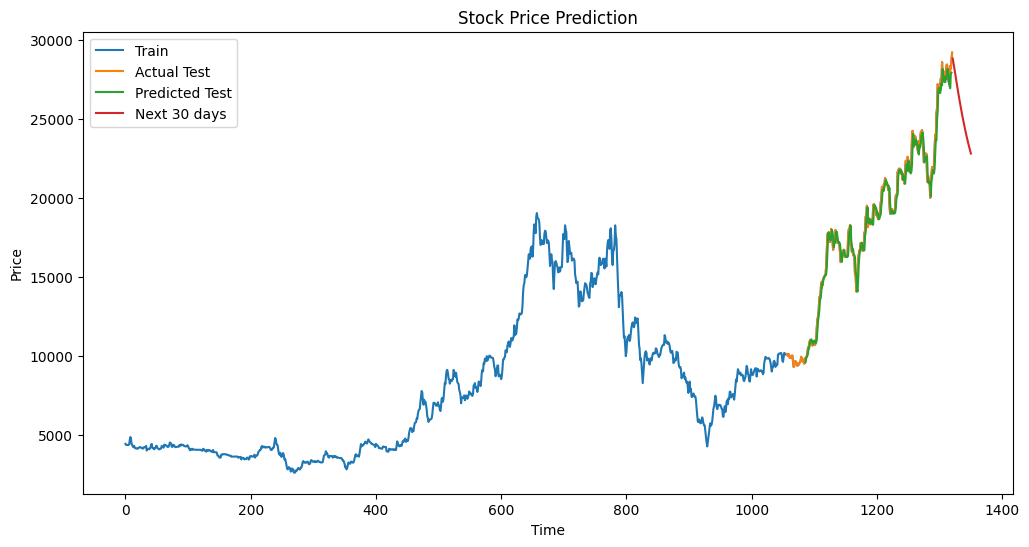

In [17]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()


# (Split 9/1)

In [18]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
df = pd.read_csv('ELC.csv', index_col='time', parse_dates=True)
df=df.drop(columns=['open', 'high', 'low', 'volume'])
df = df.reset_index(drop=True)
df.head()

,close
0,4409.937988
1,4347.826172
2,4347.826172
3,4347.826172
4,4335.403809


In [19]:
# 2. Đọc file csv và gắn index với Price
df1=df.reset_index()['close']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 4s 103ms/step - loss: 0.0483 - val_loss: 0.0456
Epoch 2/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0106 - val_loss: 0.0556
Epoch 3/100
19/19 [==============================] - 0s 22ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 4/100
19/19 [==============================] - 0s 22ms/step - loss: 5.6740e-04 - val_loss: 0.0030
Epoch 5/100
19/19 [==============================] - 0s 22ms/step - loss: 4.3777e-04 - val_loss: 0.0012
Epoch 6/100
19/19 [==============================] - 0s 22ms/step - loss: 4.1079e-04 - val_loss: 0.0012
Epoch 7/100
19/19 [==============================] - 0s 21ms/step - loss: 4.0530e-04 - val_loss: 0.0011
Epoch 8/100
19/19 [==============================] - 0s 22ms/step - loss: 3.7903e-04 - val_loss: 0.0011
Epoch 9/100
19/19 [==============================] - 0s 21ms/step - loss: 3.7082e-04 - val_loss: 9.9826e-04
Epoch 10/100
19/19 [==============================] - 0s 22ms/step - lo

In [22]:
# Dự báo dữ liệu test
y_pred = model.predict(X_test)

# Chuẩn hóa dữ liệu y_pred
y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

4/4 [==============================] - 0s 6ms/step


In [23]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAPE và MLSE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 759.52734
MAPE trên tập test là: 2.561810426414013 %
MSLE trên tập test là: 0.0010744731


In [24]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        lst_output.extend(y_hat.tolist())

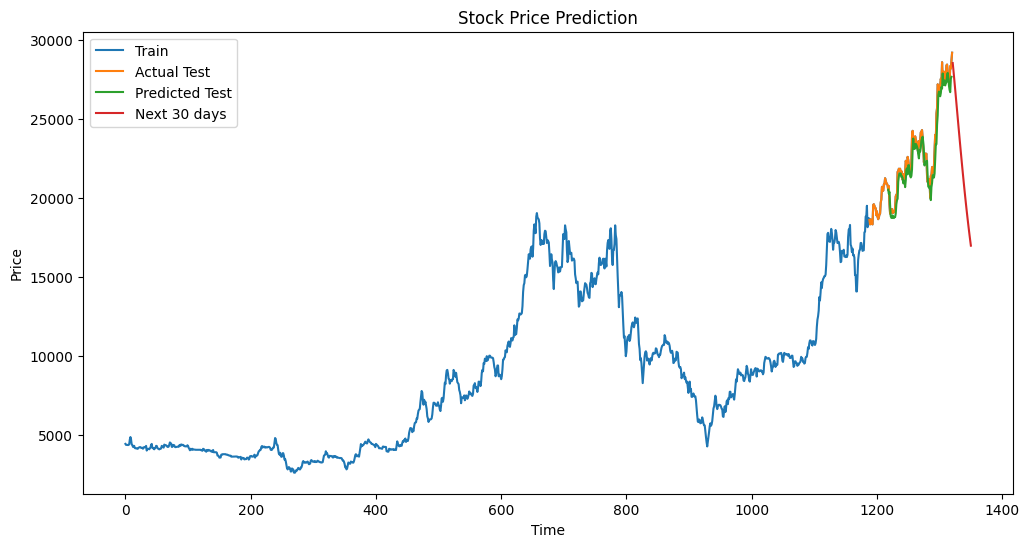

In [25]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()